2025-07-11 16:09:02,117 - INFO - Début du traitement pour UCSDped1
Chargement Test: 100%|██████████| 46/46 [01:11<00:00,  1.56s/it]
2025-07-11 16:11:10,231 - INFO - Images chargées - Train: 6800, Test: 7200


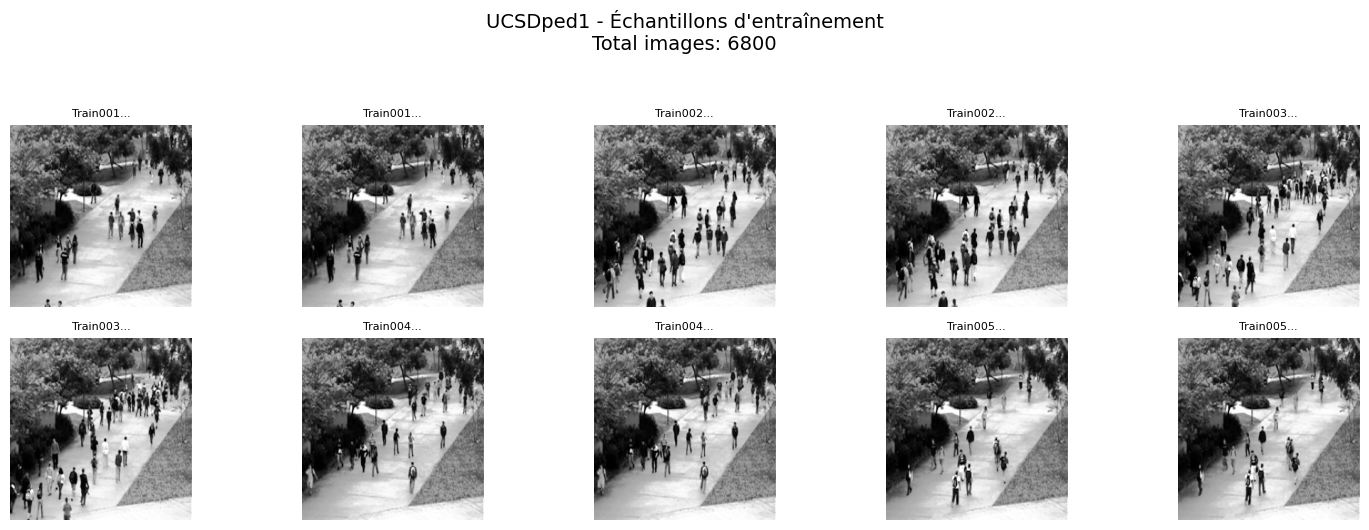

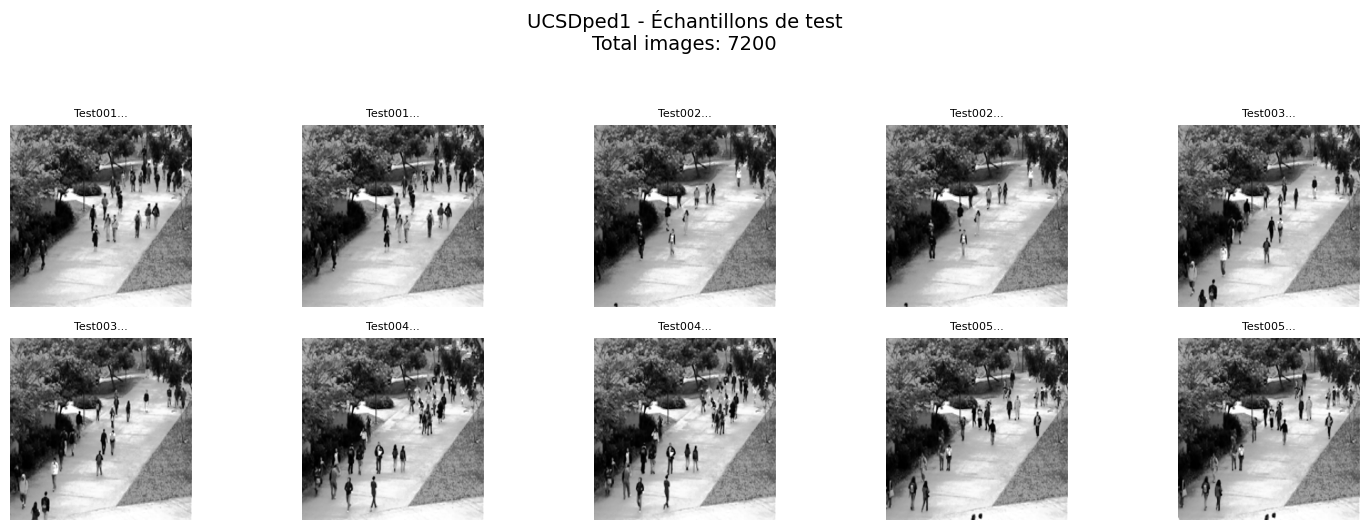

2025-07-11 16:12:15,982 - INFO - Données sauvegardées dans processed_data
2025-07-11 16:12:16,518 - INFO - Début du traitement pour UCSDped2
Chargement Test: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]
2025-07-11 16:12:50,180 - INFO - Images chargées - Train: 2550, Test: 2010


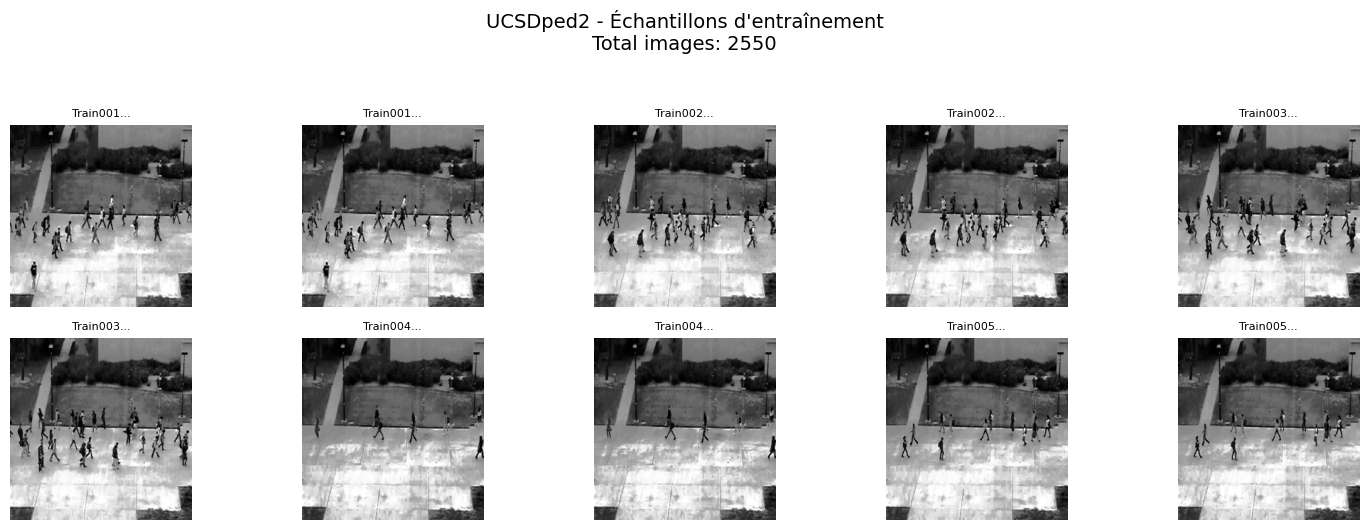

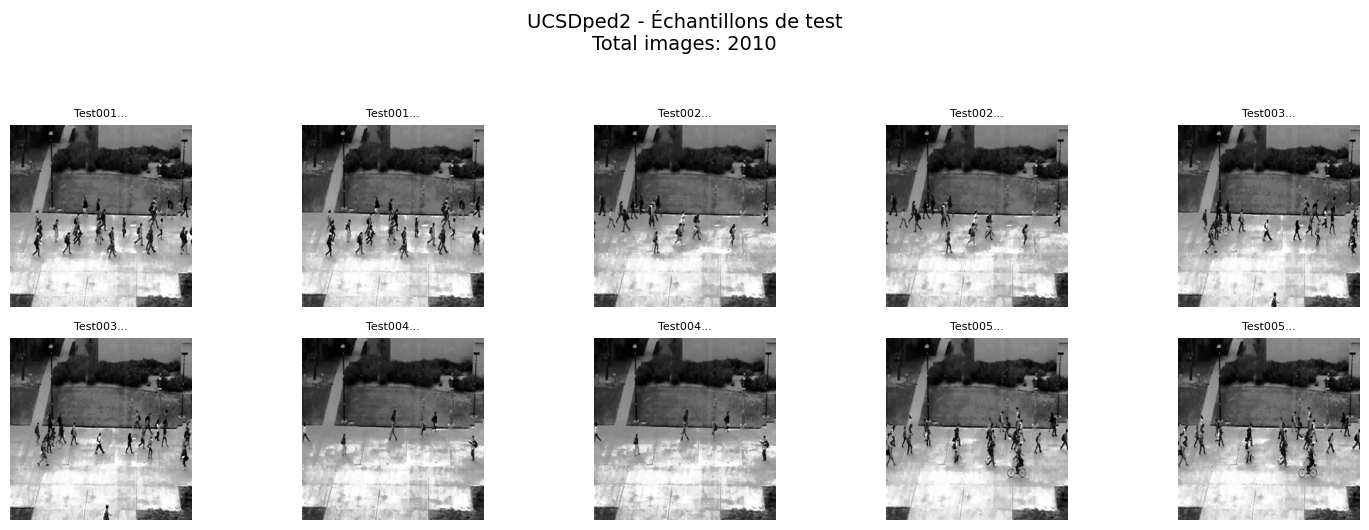

2025-07-11 16:13:01,757 - INFO - Données sauvegardées dans processed_data



Résumé du traitement:

UCSDped1:
  Images d'entraînement: 6800
  Images de test: 7200
  Shape train: (6800, 256, 256)
  Shape test: (7200, 256, 256)

UCSDped2:
  Images d'entraînement: 2550
  Images de test: 2010
  Shape train: (2550, 256, 256)
  Shape test: (2010, 256, 256)


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import logging

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('preprocessing.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

@dataclass
class DatasetConfig:
    """Configuration du dataset"""
    name: str
    path: str
    image_size: Tuple[int, int] = (256, 256)
    normalization: str = 'histogram'  # 'histogram' or 'simple'
    output_dir: str = 'processed_data'
    max_samples_to_show: int = 10  # Nombre d'échantillons à visualiser

class UCSDPreprocessor:
    """Classe principale pour le prétraitement des données UCSD"""
    
    def __init__(self, config: DatasetConfig):
        self.config = config
        self.train_data = {}
        self.test_data = {}
        self.total_train_images = 0
        self.total_test_images = 0
        self._validate_paths()
        
    def _validate_paths(self):
        """Vérification des chemins d'accès"""
        required_folders = ['Train', 'Test']
        for folder in required_folders:
            if not os.path.exists(os.path.join(self.config.path, folder)):
                raise FileNotFoundError(f"Dossier {folder} introuvable dans {self.config.path}")
        os.makedirs(self.config.output_dir, exist_ok=True)

    def _process_image(self, img_path: str) -> Optional[np.ndarray]:
        """Charge et prétraite une image"""
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                logger.warning(f"Image non lue: {img_path}")
                return None
                
            img = cv2.resize(img, self.config.image_size)
            
            if self.config.normalization == 'histogram':
                img = cv2.equalizeHist(img)
                
            return img.astype('float32') / 255.0
            
        except Exception as e:
            logger.error(f"Erreur sur {img_path}: {str(e)}")
            return None

    def _load_mode(self, mode: str) -> Tuple[Dict[str, np.ndarray], int]:
        """Charge toutes les images d'un mode (Train/Test)"""
        mode_path = os.path.join(self.config.path, mode)
        clips = sorted([
            d for d in os.listdir(mode_path) 
            if os.path.isdir(os.path.join(mode_path, d))
        ])
        
        data = {}
        total_images = 0
        
        for clip in tqdm(clips, desc=f"Chargement {mode}"):
            clip_path = os.path.join(mode_path, clip)
            images = []
            
            for img_file in sorted(os.listdir(clip_path)):
                if img_file.endswith('.tif'):
                    img = self._process_image(os.path.join(clip_path, img_file))
                    if img is not None:
                        images.append(img)
            
            if images:
                data[clip] = np.array(images)
                total_images += len(images)
                
        return data, total_images

    def _visualize_samples(self, data: Dict[str, np.ndarray], title: str):
        """Visualise des échantillons du dataset"""
        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=14, y=1.05)
        
        displayed = 0
        for clip_name, images in data.items():
            if displayed >= self.config.max_samples_to_show:
                break
                
            for img in images[:min(2, len(images))]:  # Max 2 images par clip
                if displayed >= self.config.max_samples_to_show:
                    break
                    
                plt.subplot(2, 5, displayed + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{clip_name[:15]}...", fontsize=8)
                plt.axis('off')
                displayed += 1
                
        plt.tight_layout()
        plt.show()

    def process(self) -> Dict[str, Dict]:
        """Exécute le pipeline complet"""
        logger.info(f"Début du traitement pour {self.config.name}")
        
        # Chargement des données
        self.train_data, self.total_train_images = self._load_mode('Train')
        self.test_data, self.total_test_images = self._load_mode('Test')
        
        # Affichage des statistiques
        logger.info(f"Images chargées - Train: {self.total_train_images}, Test: {self.total_test_images}")
        
        # Visualisation
        self._visualize_samples(
            self.train_data, 
            f"{self.config.name} - Échantillons d'entraînement\nTotal images: {self.total_train_images}"
        )
        self._visualize_samples(
            self.test_data, 
            f"{self.config.name} - Échantillons de test\nTotal images: {self.total_test_images}"
        )
        
        # Sauvegarde
        train_save = np.concatenate(list(self.train_data.values()))
        test_save = np.concatenate(list(self.test_data.values()))
        
        np.save(os.path.join(self.config.output_dir, f"{self.config.name}_train.npy"), train_save)
        np.save(os.path.join(self.config.output_dir, f"{self.config.name}_test.npy"), test_save)
        
        logger.info(f"Données sauvegardées dans {self.config.output_dir}")
        
        return {
            'train': self.train_data,
            'test': self.test_data,
            'stats': {
                'total_train': self.total_train_images,
                'total_test': self.total_test_images,
                'train_shape': train_save.shape,
                'test_shape': test_save.shape
            }
        }

def main():
    """Point d'entrée principal"""
    try:
        # Configuration
        datasets = [
            DatasetConfig(
                name="UCSDped1",
                path="UCSD_Anomaly_Dataset.v1p2/UCSDped1",
                image_size=(256, 256),
                normalization='histogram'
            ),
            DatasetConfig(
                name="UCSDped2",
                path="UCSD_Anomaly_Dataset.v1p2/UCSDped2",
                image_size=(256, 256),
                normalization='histogram'
            )
        ]
        
        # Traitement des datasets
        results = {}
        for config in datasets:
            processor = UCSDPreprocessor(config)
            results[config.name] = processor.process()
            
        # Affichage du résumé
        print("\nRésumé du traitement:")
        for dataset, data in results.items():
            print(f"\n{dataset}:")
            print(f"  Images d'entraînement: {data['stats']['total_train']}")
            print(f"  Images de test: {data['stats']['total_test']}")
            print(f"  Shape train: {data['stats']['train_shape']}")
            print(f"  Shape test: {data['stats']['test_shape']}")
            
    except Exception as e:
        logger.error(f"Erreur lors de l'exécution: {str(e)}")
        return 1
        
    return 0
if __name__ == '__main__':
    main()